# 0. Preprocess behavioral data
1. Zscore within subject
2. Interpolate missing data: for the missing video, find the percentile of the video in normative (group average) rating, and re-scale using the subject range
3. Save csv

*Yiyu Wang 2021 November*

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
from scipy.stats import zscore

import warnings
warnings.filterwarnings('ignore')

In [2]:

# set up directories
data_dir = "logfiles"
behavdata_dir = 'BehavData'
category = ['Heights','Social','Spider']

# remove excluded runs:
sub_id = pd.Series(['07', '14','23','26'])
excluded_run = pd.DataFrame({'SUBID':sub_id, 'run':pd.Series([3,3,1,3])})


# flip valence so that higher valence = negative; lower valence = positive
# positive weight meaning predicting negative valence
# negative weight meaning predicting positive valence

# subject information

subjects_list = ['04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','23','25','26','28','29']
print(subjects_list)



logfile_headers =np.array(['video_name', 'run_number', 'video_category', 'experimenter_high_low', 'same_category_prior', 
                  'cue_onset','cue_offset', 'expected_fear', 'expected_fear_RT',
                 'video_onset', 'video_offset', 'fear_rating', 'arousal_rating', 'valence_rating',
                  'fear_rating_RT', 'arousal_rating_RT', 'valence_rating_RT'])

save = True

['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '23', '25', '26', '28', '29']


In [3]:
def interpolate_rating(norm_min, norm_max, norm_rating, sub_min, sub_max):
    scale = norm_rating / (norm_max - norm_min) 
    sub_rating = scale * (sub_max - sub_min)
    
    return sub_rating


def get_video_n(video_name):
    # category
    if video_name[0:2]=='he':
        temp = 0
    elif video_name[0:2] == 'so':
        temp = 12
    else:
        temp = 24
    num = video_name[-5:-4]
    # high vs low
    if video_name[-9:-7] == 'lo':
        temp = temp + 6
        
    # social_high_4_replacement  
    if num == 't':
        temp = 16
    else:
        num = int(num)
        temp = temp + num
    return int(temp)

def get_vcat(cn):
    if cn == 1:
        cat = 'Heights'

    elif cn == 2:
        cat = 'Social'

    elif cn == 3:
        cat = 'Spiders'
    else:
        print('no such category number!')
    return cat 

def parse_task_lines(sub_id, lines, headers):
    for (i, line) in enumerate(lines):
        
        cols = line.split(' ')
        video_name = cols[int(np.where(headers == 'video_name')[0])]
        video_number = get_video_n(video_name)
        
        category_number = int(cols[int(np.where(headers == 'video_category')[0])])
        video_category = get_vcat(category_number)
        
        video_onset = float(cols[int(np.where(headers == 'video_onset')[0])])
        video_offset = float(cols[int(np.where(headers == 'video_offset')[0])])  
        video_duration = video_offset - video_onset

        run = int(cols[int(np.where(headers == 'run_number')[0])])
        expected_rating = abs(float(cols[int(np.where(headers == 'expected_fear')[0])]))
        fear_rating = abs(float(cols[int(np.where(headers == 'fear_rating')[0])]))
        arousal_rating = abs(float(cols[int(np.where(headers == 'arousal_rating')[0])]))
        valence_rating = abs(float(cols[int(np.where(headers == 'valence_rating')[0])]))
        
        yield [sub_id, run, video_number, category_number, video_category, expected_rating, fear_rating, arousal_rating, valence_rating ]
        


In [30]:
# create data frame that contains all subjects' ratings
df_all = pd.DataFrame()
ratings = pd.DataFrame()
vnlist = []
for logfiles in glob.glob(data_dir +'/*.txt'):
    df = np.loadtxt(logfiles,skiprows=1,dtype =str)
    df = pd.DataFrame(df)
    
    sub_id = logfiles[-13:-11]
    # fix subject number
    if sub_id[0] =='_':
        sub_id = list(sub_id)
        sub_id[0] = '0'      
        sub_id = "".join(sub_id)       
    sub_id = pd.to_numeric(sub_id)
    
    #store video name
    vn = pd.DataFrame(columns=['sub_id','run','video_num', 'cat']) 
    for v in range(0,36):
        video_num = get_video_n(df.iloc[v,0])
        vnlist.append(video_num)
        vn.loc[v] = pd.Series({'video_num':video_num})
        vn.loc[v,'run'] =df.iloc[v,1]
        
        category_number_col_index = int(np.where(logfile_headers == 'video_category')[0])
        category_number = int(df.iloc[v, category_number_col_index])
        vn.loc[v,'cat'] = get_vcat(category_number)
        
        
    vn['sub_id'] = sub_id
    

    ratings = pd.DataFrame(df.iloc[0:36,[7,11,12,13]])
    ratings.columns = ['expected_fear','fear','arousal','valence']
    
    # data frame with rating for each subject
    df_sub = pd.concat([vn,ratings],axis = 1)
    df_all = pd.concat([df_all, df_sub],axis = 0, ignore_index=True)
    


    
df_all['expected_fear'] = pd.to_numeric(df_all['expected_fear'], errors='coerce')
df_all['fear'] = pd.to_numeric(df_all['fear'], errors='coerce')
df_all['arousal'] = pd.to_numeric(df_all['arousal'], errors='coerce')
df_all['valence'] = pd.to_numeric(df_all['valence'], errors='coerce')
df_all['PEfear'] = df_all.apply(lambda row: row.expected_fear - row.fear, axis =1)
df_all['cat'] = 'Social'
df_all.loc[df_all.video_num < 13,'cat'] = 'Heights'
df_all.loc[df_all.video_num > 24,'cat'] = 'Spiders'  
df_all['cat'] =df_all['cat'].astype(str)


# participant 19 had one fear rating of 1.12, reset to 1:
df_all.loc[df_all.fear > 1,'fear'] = 1
df_all.head()

,sub_id,run,video_num,cat,expected_fear,fear,arousal,valence,PEfear
0,16,1,16.0,Social,0.000,0.000,0.000,0.499,0.000
1,16,1,21.0,Social,0.000,0.000,0.132,0.683,0.000
2,16,1,13.0,Social,0.143,0.446,0.499,0.883,-0.303
3,16,1,1.0,Heights,0.000,0.000,0.727,0.503,0.000
4,16,1,26.0,Spiders,0.000,0.000,0.293,0.498,0.000


In [32]:
cat_col = df_sub.sort_values(by='video_num').reset_index()
cat_col = cat_col['cat'].values
cat_col

array(['Heights', 'Heights', 'Heights', 'Heights', 'Heights', 'Heights',
       'Heights', 'Heights', 'Heights', 'Heights', 'Heights', 'Heights',
       'Social', 'Social', 'Social', 'Social', 'Social', 'Social',
       'Social', 'Social', 'Social', 'Social', 'Social', 'Social',
       'Spiders', 'Spiders', 'Spiders', 'Spiders', 'Spiders', 'Spiders',
       'Spiders', 'Spiders', 'Spiders', 'Spiders', 'Spiders', 'Spiders'],
      dtype=object)

In [33]:
# create a dataframe for group ratings
avg_df = df_all.copy().drop(columns=['sub_id','run','cat'])
mean_df = avg_df.groupby('video_num').mean()
std_df = avg_df.groupby('video_num').std()
sem_df = avg_df.groupby('video_num').sem()
group_df = pd.concat([mean_df, sem_df, std_df],axis=1).reset_index()
    


column_list = ["video_num", "expected_fear","fear","arousal","valence","PEFear",
               "sem_PredFear","sem_fear","sem_arousal","sem_valence","sem_PEFear",
              "std_PredFear","std_fear","std_arousal","std_valence","std_PEFear"]
group_df.columns = column_list


group_df['cat'] = pd.Series(cat_col)
group_df.head(20)

,video_num,expected_fear,fear,arousal,valence,PEFear,sem_PredFear,sem_fear,sem_arousal,sem_valence,sem_PEFear,std_PredFear,std_fear,std_arousal,std_valence,std_PEFear,cat
0,1.0,0.401238,0.697158,0.720000,0.244905,-0.272105,0.068580,0.077004,0.053054,0.044518,0.063164,0.314275,0.335655,0.243124,0.204008,0.275325,Heights
1,2.0,0.449619,0.744333,0.720238,0.283286,-0.294714,0.070341,0.056265,0.049566,0.047585,0.061743,0.322344,0.257838,0.227141,0.218060,0.282941,Heights
2,3.0,0.427778,0.798850,0.800800,0.199684,-0.398833,0.073449,0.056483,0.057805,0.047225,0.069042,0.311617,0.252599,0.258511,0.205850,0.292922,Heights
3,4.0,0.423000,0.655700,0.718048,0.343143,-0.196944,0.073995,0.069076,0.053847,0.060041,0.057161,0.322537,0.308919,0.246759,0.275142,0.242515,Heights
4,5.0,0.387150,0.681524,0.753524,0.367800,-0.285050,0.068237,0.059539,0.053114,0.048533,0.056889,0.305165,0.272843,0.243400,0.217048,0.254415,Heights
5,6.0,0.431150,0.683095,0.776762,0.309190,-0.241200,0.068274,0.054079,0.033662,0.046326,0.051584,0.305329,0.247820,0.154257,0.212291,0.230691,Heights
6,7.0,0.450250,0.161400,0.359800,0.685857,0.278053,0.076976,0.046509,0.059659,0.051863,0.063934,0.344249,0.207996,0.266805,0.237665,0.278684,Heights
7,8.0,0.477050,0.091190,0.347700,0.753952,0.381300,0.067604,0.024225,0.058899,0.041869,0.061046,0.302335,0.111015,0.263405,0.191866,0.273005,Heights
8,9.0,0.468381,0.114263,0.332550,0.753450,0.349053,0.065935,0.037508,0.063697,0.048207,0.062250,0.302152,0.163492,0.284861,0.215587,0.271342,Heights
9,10.0,0.463000,0.221950,0.544667,0.641333,0.248000,0.067726,0.049027,0.053810,0.055782,0.063680,0.310360,0.219257,0.246590,0.255626,0.284784,Heights


In [40]:
all_sub_df = pd.DataFrame(columns=['sub_id','run','video_number','video_category','category','expected_fear','fear','arousal','valence'])


for s in subjects_list:
    task_file = glob.glob(data_dir + f'/AffVids_logfile_{s}_edited.txt') 
    task_csv = task_file[0]
    
    task_lines =[]     
    with open(task_csv, 'r') as task_csv_file:
        task_lines.append(list(parse_task_lines(s, task_csv_file.readlines()[1:], logfile_headers)))
        
    sub_df = pd.DataFrame(task_lines[0], columns=all_sub_df.columns)
    
    # check missing data, and interpolate:
    for which_rating in ['expected_fear','fear', 'arousal','valence']:
        row_idx_list = sub_df[sub_df[which_rating].isnull()].index.tolist()
        
        if bool(row_idx_list):
            print(f'subject {s} interpolated {len(row_idx_list)} item(s) in {which_rating}')
            for i in range(len(row_idx_list)):
                row_idx = row_idx_list[i]
                sub_idx = sub_df.columns.get_loc("sub_id")
                sub_id = sub_df.iloc[row_idx, sub_idx]
                cat_idx = sub_df.columns.get_loc("category")
                video_cat = sub_df.iloc[row_idx, cat_idx]
                video_idx = sub_df.columns.get_loc("video_number")
                video_number = sub_df.iloc[row_idx, video_idx]

                #find range of the same category:
                sub_max = np.nanmax(sub_df[sub_df.category==video_cat][which_rating])
                sub_min = np.nanmin(sub_df[sub_df.category==video_cat][which_rating])

                norm_max = np.nanmax(group_df[group_df.cat==video_cat][which_rating])
                norm_min = np.nanmin(group_df[group_df.cat==video_cat][which_rating])

                norm_rating = group_df[group_df.video_num==video_number][which_rating].reset_index(drop=True)
                # interpolate subject rating:
                sub_rating = interpolate_rating(norm_min, norm_max, norm_rating[0], sub_min, sub_max)
                sub_df.loc[row_idx,which_rating] = sub_rating

    all_sub_df = all_sub_df.append(sub_df,ignore_index=True)


all_sub_df.loc[all_sub_df.fear > 1,'fear'] = 1

subject 04 interpolated 1 item(s) in valence
subject 05 interpolated 1 item(s) in fear
subject 05 interpolated 3 item(s) in valence
subject 07 interpolated 1 item(s) in valence
subject 08 interpolated 1 item(s) in arousal
subject 10 interpolated 1 item(s) in fear
subject 13 interpolated 1 item(s) in expected_fear
subject 13 interpolated 2 item(s) in valence
subject 14 interpolated 1 item(s) in fear
subject 15 interpolated 5 item(s) in expected_fear
subject 15 interpolated 6 item(s) in fear
subject 15 interpolated 1 item(s) in arousal
subject 15 interpolated 2 item(s) in valence
subject 17 interpolated 2 item(s) in expected_fear
subject 17 interpolated 1 item(s) in arousal
subject 18 interpolated 1 item(s) in expected_fear
subject 18 interpolated 1 item(s) in fear
subject 18 interpolated 2 item(s) in arousal
subject 18 interpolated 1 item(s) in valence
subject 19 interpolated 4 item(s) in expected_fear
subject 19 interpolated 6 item(s) in fear
subject 19 interpolated 5 item(s) in arousa

In [41]:

#save

if save:
    all_sub_df.to_csv(behavdata_dir +'/AffVids_novel_interpolated_rating_raw.csv')
# flip valence:
all_sub_df['valence'] = 1- all_sub_df['valence']
if save:
    all_sub_df.to_csv(behavdata_dir +'/AffVids_novel_interpolated_rating_raw_flipped_valence.csv')

In [42]:
ratings_zscored = all_sub_df.copy()
ratings_demeaned = all_sub_df.copy()

cols = ['fear', 'arousal','valence']
for s in subjects_list:
    for col in cols:
        ratings_zscored.loc[ratings_zscored['sub_id'] == s,col] = zscore(ratings_zscored.loc[ratings_zscored['sub_id'] == s,col],axis=0, ddof=0)
        
        ratings_demeaned.loc[ratings_demeaned['sub_id'] == s,col] = ratings_demeaned.loc[ratings_demeaned['sub_id'] == s,col] - np.mean(ratings_demeaned.loc[ratings_demeaned['sub_id'] == s,col])

if save:        
    ratings_zscored.to_csv(behavdata_dir +'/AffVids_novel_interpolated_rating_zscored.csv')
    ratings_demeaned.to_csv(behavdata_dir +'/AffVids_novel_interpolated_rating_demeaned.csv')



In [43]:
# check no nan:
all_sub_df.isnull().sum()

sub_id            0
run               0
video_number      0
video_category    0
category          0
expected_fear     0
fear              0
arousal           0
valence           0
dtype: int64

## Make fear plots:

In [47]:
# sort everyone's rating
# then make line plot per person

sorted_ratings = all_sub_df.sort_values(by =['sub_id','video_category','fear'])

import plotly.express as px
for category in np.unique(sorted_ratings['category']):
    plot_df = sorted_ratings[sorted_ratings.category==category]
    plot_df['video_order']=np.tile(range(1,13), len(subjects_list))
    
    fig = px.line(plot_df, x='video_order', y='fear', color='sub_id', markers=False,width=500, height=400)
    fig.update_layout(xaxis_title="Videos", 
                      yaxis_title="Fear ratings",
                        title=dict(text=f"Fear Ratings by Subject: {category}", x=0.5, y=0.95,
                                   font=dict(size=24)))
    fig.update_xaxes(showline=True, linewidth=2, linecolor='black',showgrid=False, zeroline=False, range=[0.5, 12.5],title_font=dict(size=22),tickfont=dict(size=18),nticks=24)
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black',showgrid=True, zeroline=False, range=[-0.1,1.1],title_font=dict(size=22),tickfont=dict(size=18))
    

    fig.update_layout(
        title_font_family="Times New Roman",showlegend=False
    )
    fig.show()
    
    

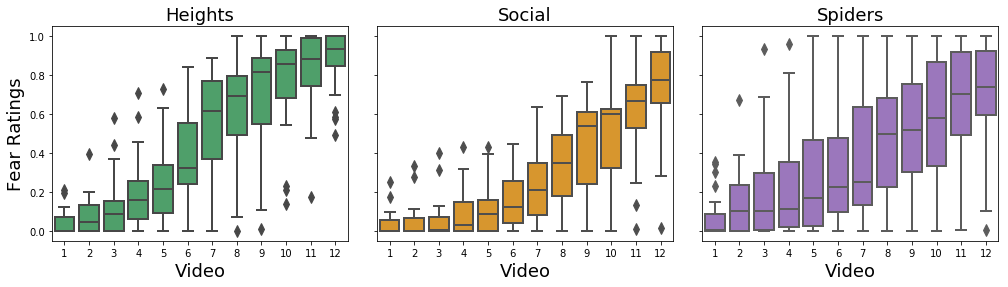

In [91]:
my_colors = ['#42AC65', '#F39C12', '#9C6CC7']
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes= plt.subplots(1, 3, figsize=(14,4))
for n, category in enumerate(['Heights','Social','Spiders']):
    plot_df = sorted_ratings[sorted_ratings.category==category]
    plot_df['video_order']=np.tile(range(1,13), len(subjects_list))
    c = my_colors[n]
    sns.boxplot(data=plot_df, x='video_order', y='fear', color = c,ax=axes[n],linewidth=2, fliersize=8)
    axes[n].set_title(category,fontsize =18)
    #axes[n].set_xticks()
    #axes[n].set_xticklabels(all_df[n]['video_num'].apply(int).apply(str),fontsize =14)

    axes[n].set_ylim(-0.05,1.05)
    plt.tight_layout()
    plt.show   

    
for ax in axes.flat:
    ax.set_xlabel('Video', fontsize=18)
    ax.set_ylabel('Fear Ratings', fontsize=18) 
    
for ax in axes.flat:
       ax.label_outer()
plt.subplots_adjust(wspace=0.1, hspace=0)